<a href="https://colab.research.google.com/github/MohammadAghaei1/Plantdoc-image-processing/blob/main/Plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset**

In [168]:
!git clone https://github.com/MohammadAghaei1/Plantdoc-image-processing

fatal: destination path 'Plantdoc-image-processing' already exists and is not an empty directory.


In [169]:
!unzip /content/Plantdoc-image-processing/Dataset/PlantDoc\ 416x416.zip

Archive:  /content/Plantdoc-image-processing/Dataset/PlantDoc 416x416.zip
replace train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg  
 extracting: train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg  
 extracting: train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg  
 extracting: train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg  
 extracting: train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg  
 extracting: train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg  
 extracting: train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg  
 extracting: train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg  
 extracti

In [170]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# **Data Preparation**

In [171]:
annotation_path = '/content/train/_annotations.csv'

In [172]:
problematic_lines = []
expected_cols = 8

with open(annotation_path, 'r') as f:
    reader = csv.reader(f)
    # Skip the header row
    header = next(reader)
    for i, row in enumerate(reader):
        if len(row) != expected_cols:
            problematic_lines.append((i + 2, row))

if problematic_lines:
    with open('problematic_lines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Line Number', 'Problematic Row Content'])
        for line_num, row_content in problematic_lines:
            writer.writerow([line_num, ','.join(row_content)])

    print(f"Found {len(problematic_lines)} problematic lines. Details saved to 'problematic_lines.csv'.")
    print("Please review 'problematic_lines.csv' and fix the data in the original file.")
else:
    print("No problematic lines found in the annotation file.")

Found 34 problematic lines. Details saved to 'problematic_lines.csv'.
Please review 'problematic_lines.csv' and fix the data in the original file.


In [173]:
ANNOTATIONS = Path(annotation_path)
ENCODING    = "utf-8-sig"
OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


def is_int_token(s: str) -> bool:
    s = s.strip()
    if s.startswith(("+","-")): s = s[1:]
    return s.isdigit()

def first_consecutive_int_pair(tokens):
    """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
    for i in range(len(tokens) - 1):
        if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
            return i
    return None

def rebuild_row(tokens):
    """
    tokens: list obtained by naive comma split via csv.reader
    returns (ok, row_or_reason)
    row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
    """
    toks = [t.strip() for t in tokens if t is not None]

    # 1) locate width,height as the first consecutive int pair
    w_idx = first_consecutive_int_pair(toks)
    if w_idx is None:
        return False, "no consecutive width,height integers found"

    filename = ",".join(toks[:w_idx]).strip().strip('"')
    width, height = toks[w_idx], toks[w_idx + 1]
    rest = toks[w_idx + 2:]

    # Need at least 5 tokens after height (some class + 4 bbox ints)
    if len(rest) < 5:
        return False, "not enough fields after height"

    # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
    bbox_indices = []
    for j in range(len(rest) - 1, -1, -1):
        if is_int_token(rest[j]):
            bbox_indices.append(j)
            if len(bbox_indices) == 4:
                break
    if len(bbox_indices) != 4:
        return False, "could not find 4 bbox integers in tail"
    bbox_indices.sort()
    xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

    # 3) class = everything between height and earliest bbox int
    class_tokens = rest[:bbox_indices[0]]
    if not class_tokens:
        return False, "class field missing"
    class_name = ",".join(class_tokens).strip().strip('"')

    return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

def main():
    fixed, bad = [], []

    with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
        rdr = csv.reader(f)
        _ = next(rdr, None)  # skip original header if present
        for row in rdr:
            ok, out = rebuild_row(row)
            if ok:
                fixed.append(out)
            else:
                bad.append({"reason": out, "raw": ",".join(row)})

    # Write clean file
    with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(EXPECTED_HEADER)
        w.writerows(fixed)

    # Write any unfixable rows for manual check
    with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(["reason","raw_line"])
        for br in bad:
            w.writerow([br["reason"], br["raw"]])

    print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
    print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

if __name__ == "__main__":
    main()


 Clean rows written: 8353 -> /content/train/_annotations_clean.csv
 Unfixable empty rows: 10 -> /content/train/_annotations_unfixable.csv


In [174]:
annotation = pd.read_csv('/content/train/_annotations_clean.csv')

In [175]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8353 non-null   object
 1   width     8353 non-null   int64 
 2   height    8353 non-null   int64 
 3   class     8353 non-null   object
 4   xmin      8353 non-null   int64 
 5   ymin      8353 non-null   int64 
 6   xmax      8353 non-null   int64 
 7   ymax      8353 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 522.2+ KB


In [176]:
base_dir = Path("/content/train")

missing_files = [
    f for f in annotation["filename"].unique()
    if not (base_dir / f).exists()
]

if missing_files:
    pd.Series(missing_files, name="filename").to_csv("missing_images.csv", index=False)
    print(f"⚠ Found {len(missing_files)} missing files. Saved to missing_images.csv")
else:
    print(" All files exist. No action needed.")


 All files exist. No action needed.


In [177]:
duplicate_rows = annotation.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


# **EDA**

In [178]:
num_classes = annotation['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 30


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            58
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot              104
Tomato leaf late blight   

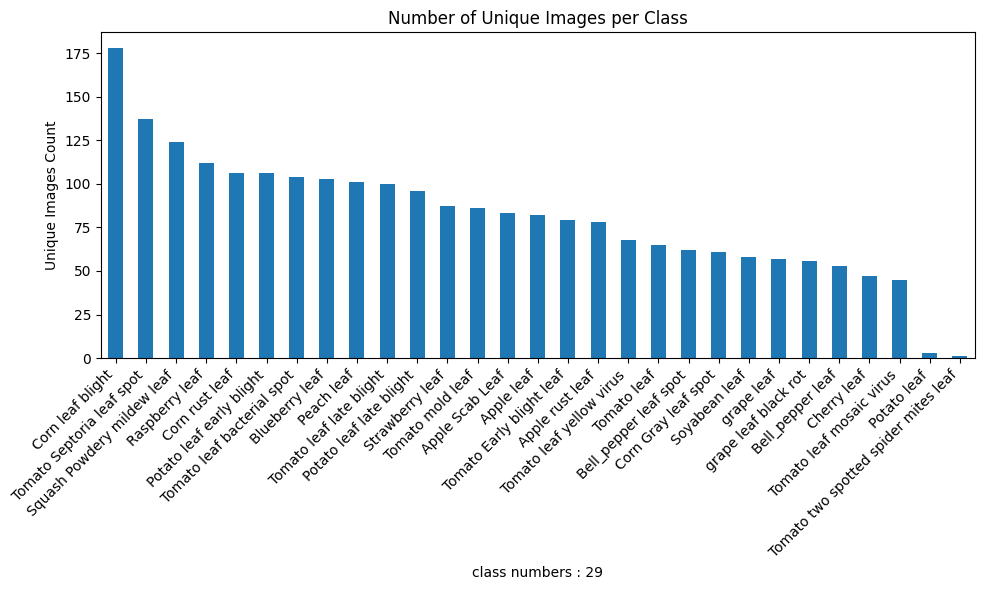

In [187]:
img_per_class = annotation.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [180]:
annotation['class'] = annotation['class'].replace('Soybean leaf', 'Soyabean leaf')
print("Changed 'Soybean leaf' to 'Soyabean leaf'")

Changed 'Soybean leaf' to 'Soyabean leaf'


class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Squash Powdery mildew leaf              248
Bell_pepper leaf spot                   248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                193
Apple rust leaf           

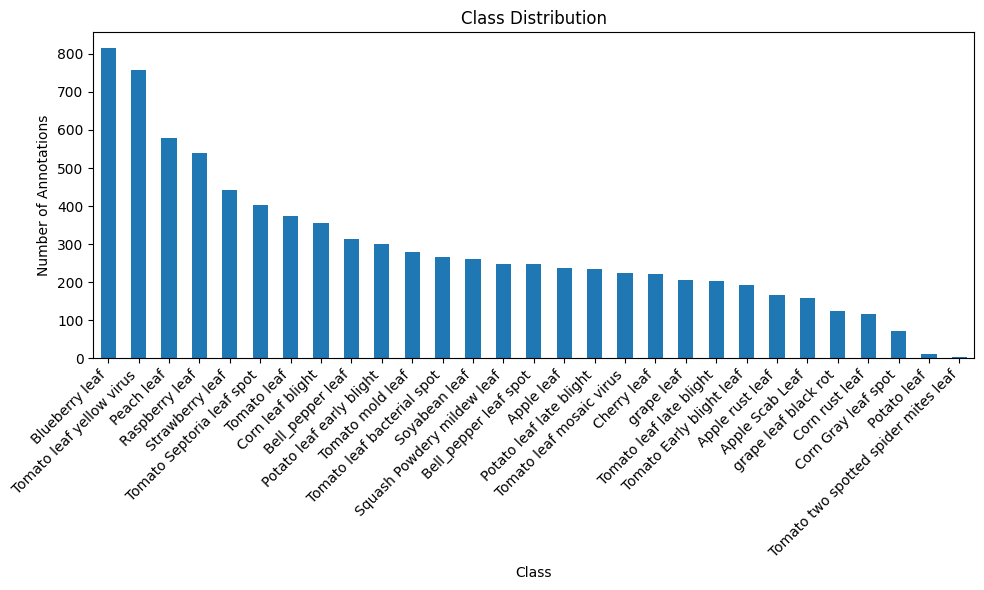

In [181]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [182]:
num_classes = annotation['class'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 29


In [183]:
cell_name = "SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg"
annotation.loc[
    (annotation["filename"] == cell_name) &
    (annotation["class"] == "Tomato two spotted spider mites leaf"),
    "class"
] = "Tomato Early blight leaf"

print(f"Updated class for filename: {cell_name}")

Updated class for filename: SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            58
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot              104
Tomato leaf late blight   

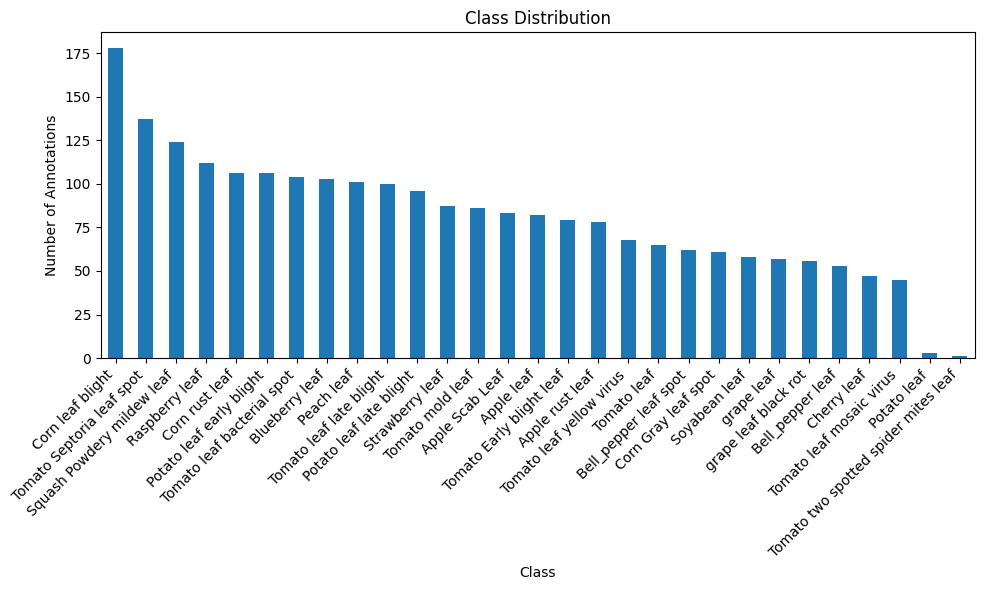

In [184]:
class_counts = annotation.groupby("class")["filename"].nunique()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Squash Powdery mildew leaf              248
Bell_pepper leaf spot                   248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                194
Apple rust leaf           

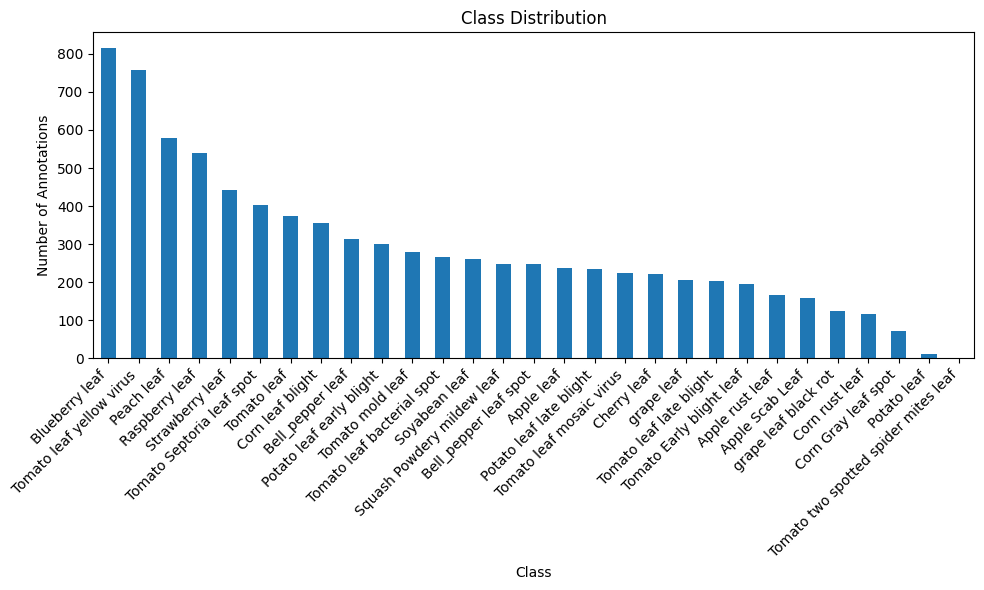

In [185]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
